# How to work with the dataset
this notebook requires also tf

In [1]:
import f110_gym
import f110_orl_dataset
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

F110Env = gym.make('f110_with_dataset-v0',
    # only terminals are available as of tight now 
        **dict(name='f110_with_dataset-v0',
            config = dict(map="Infsaal", num_agents=1),
              render_mode="human")
    ) 

{'config': {'map': 'Infsaal', 'num_agents': 1}, 'render_mode': 'human'}
Infsaal_map.pgm
Infsaal_map.pgm
hi
Infsaal_map.pgm
Infsaal_map.pgm
===
Box([[-0.4189 -5.    ]], [[ 0.4189 20.    ]], (1, 2), float32)
low
20
Box([-30.     -30.      -1.      -1.     -20.     -20.     -20.      -0.4189
   0.5     -1.      -1.    ], [30.     30.      1.      1.     20.     20.     20.      0.4189  2.
  1.      1.    ], (11,), float32)
***********


/home/fabian/msc/f110_dope/rollouts/f1tenth_gym/gym/f110_gym/envs/integrator.py:13: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(


Now we load the dataset. Make sure the absolute path to the dataset is correct. This will be nicer at some point. 

In [2]:
root = F110Env.get_dataset(zarr_path="/home/fabian/msc/f110_dope/ws_release/datasets_1412.zarr",
                            alternate_reward=False, # if we compute a new reward, set this to true
                            # I believe the arguments below should be used mutually exclusively
                            # only_agents=['StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0'], # here we can only use specific agents
                            without_agents = ['StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0', # here we can exclude specific agents
                                              'StochasticContinousFTGAgent_0.5_5_0.2_0.3_2.0',
                                              'StochasticContinousFTGAgent_5.0_2_0.2_0.3_2.0',
                                              'StochasticContinousFTGAgent_5.0_5_0.2_0.3_2.0'],
                            clip_trajectory_length=(0,250),
                            )

/home/fabian/miniconda3/envs/tf/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_dataset to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_dataset` for environment variables or `env.get_wrapper_attr('get_dataset')` that will search the reminding wrappers.
  logger.warn(


/home/fabian/msc/f110_dope/ws_release/datasets_1412.zarr
['StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_0.5_5_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_1.0_2_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_1.0_5_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_3.0_2_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_3.0_5_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_5.0_2_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_5.0_5_0.2_0.3_2.0']
len(model_names) 400145
Indices: 200086
[150059 150060 150061 ... 350142 350143 350144]
(200086,)
ang_vels_z
lidar_occupancy
linear_vels_x
linear_vels_y
poses_x
poses_y
previous_action
progress_cos
progress_sin
theta_cos
theta_sin
Number of timesteps: 99836


In [3]:

print(root["observations"].shape)
print(root["actions"].shape)
print(np.unique(root["infos"]["model_name"]))
print(root.keys())
print(root["infos"].keys())

(99836, 11)
(99836, 2)
['StochasticContinousFTGAgent_1.0_2_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_1.0_5_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_3.0_2_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_3.0_5_0.2_0.3_2.0']
dict_keys(['rewards', 'terminals', 'timeouts', 'actions', 'log_probs', 'raw_actions', 'index', 'observations', 'scans', 'infos'])
dict_keys(['model_name'])


In [6]:
# if you want you can plot stuff from the dataset here
import plot_utilities as pu
import importlib
# To reload the module:
importlib.reload(pu)

alternate_reward = False
timesteps = [250]
gamma = 0.99
target_datasets = ["datasets_1412.zarr"]

all_rewards = dict()

rewards_dict = {target: {str(timestep): {} for timestep in timesteps} for target in target_datasets}

for i, target in enumerate(target_datasets):
    for timestep in timesteps:
        # load the dataset
        dataset =  F110Env.get_dataset(
                        zarr_path= f"/home/fabian/msc/f110_dope/ws_release/{target}", 
                        alternate_reward=alternate_reward,
                        include_timesteps_in_obs=True,
                        only_terminals=True,
                        clip_trajectory_length=(0,timestep),
                        )
        returns, std = pu.compute_returns(dataset, gamma)
        #print(returns, std)
        for key in returns.keys():
            rewards_dict[target][str(timestep)][key] = {}
            rewards_dict[target][str(timestep)][key]["mean"] = returns[key]
            rewards_dict[target][str(timestep)][key]["std"] = std[key]
        
all_rewards["ground_truth"] = rewards_dict
print(all_rewards)

/home/fabian/msc/f110_dope/ws_release/datasets_1412.zarr
['StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_0.5_5_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_1.0_2_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_1.0_5_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_3.0_2_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_3.0_5_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_5.0_2_0.2_0.3_2.0'
 'StochasticContinousFTGAgent_5.0_5_0.2_0.3_2.0']
len(model_names) 400145
Indices: 400145
[     0      1      2 ... 400142 400143 400144]
(400145,)
ang_vels_z
lidar_occupancy
linear_vels_x
linear_vels_y
poses_x
poses_y
previous_action
progress_cos
progress_sin
theta_cos
theta_sin
Number of timesteps: 199895
199895
[25030, 50030, 75059, 100088, 125088, 150145, 175145, 199895]
{'ground_truth': {'datasets_1412.zarr': {'250': {'StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0': {'mean': 0.2780495509310634, 'std': 0.033649822129264685}, 'StochasticContinousFTGAgent_5.0_5_0.2_0.3_2.0': {'mean': 0.21257

Statistics for each model:


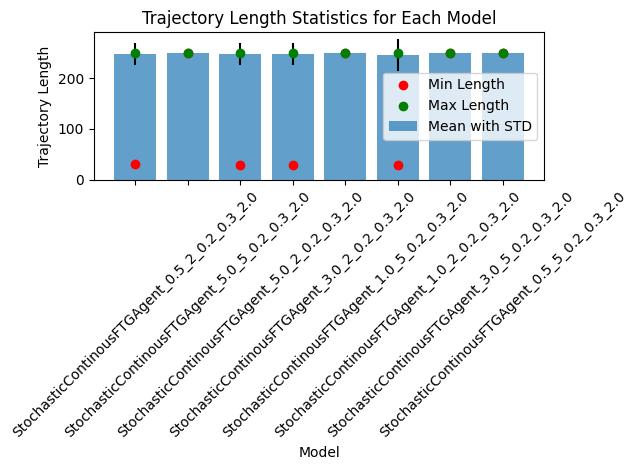

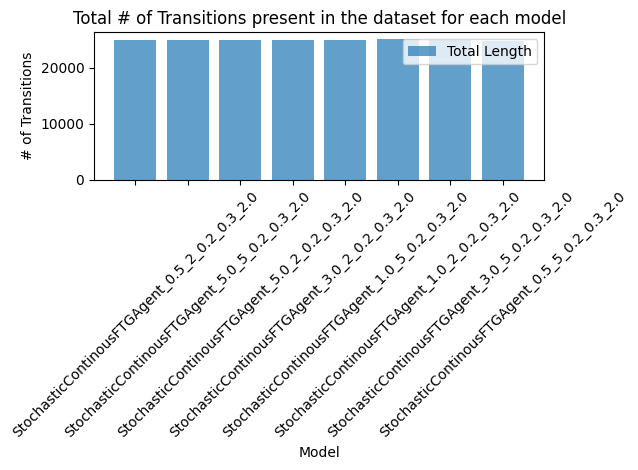

In [7]:
pu.dataset_statistics(dataset)

['ground_truth']
dict_keys(['ground_truth'])
dict_keys(['250'])


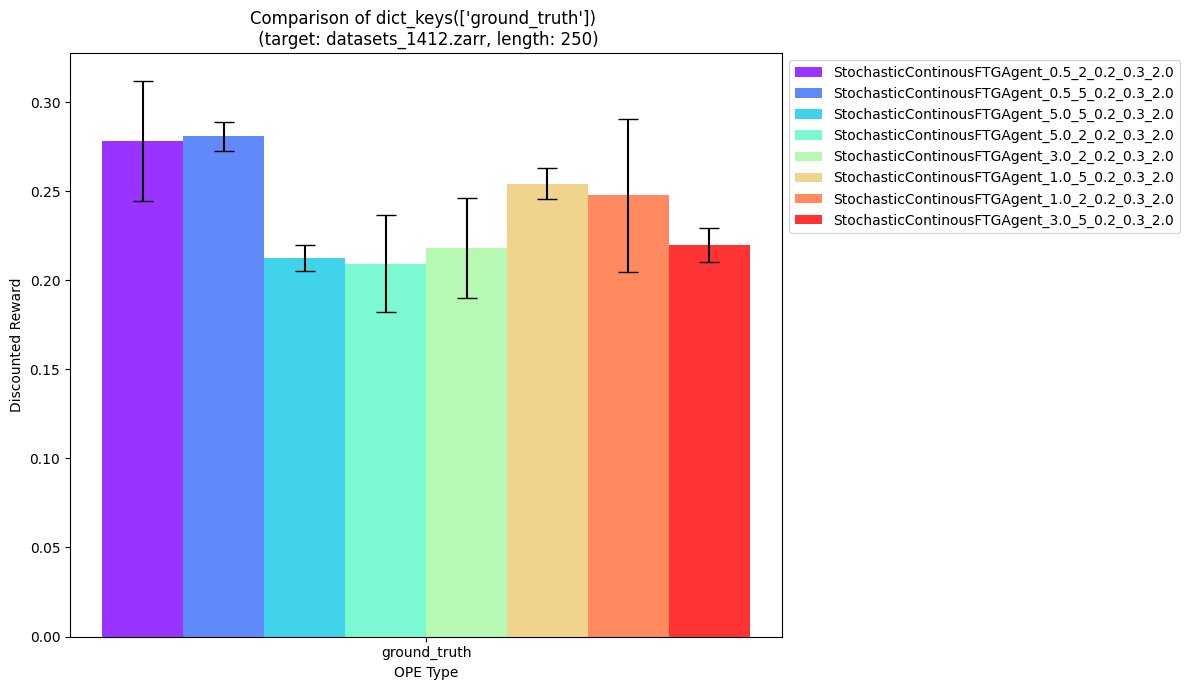

In [11]:
"""
logdir = "logdir_torch/mixed_agents"
all_rewards["fqe"] = pu.traverse_logdir(logdir, method='fqe', 
                                    tag_pred='eval/mean_fqe',
                                    tag_std='eval/std_fqe',
                                    minimum_evals=3)
all_rewards["dr"] = pu.traverse_logdir(logdir, method='fqe_dr', 
                                    tag_pred='eval/mean_fqe',
                                    tag_std='eval/std_fqe',
                                    minimum_evals=1)
import pprint
"""
all_rewards = pu.post_process_rewards(all_rewards)
pu.plot_bars_from_dict(all_rewards, 
                        target="datasets_1412.zarr", 
                        length='250', 
                        methods= ["ground_truth"],
                        sub_keys=["StochasticContinousFTGAgent_0.5_2_0.2_0.3_2.0",
                                   "StochasticContinousFTGAgent_0.5_5_0.2_0.3_2.0" ,
                                  "StochasticContinousFTGAgent_5.0_5_0.2_0.3_2.0", 
                                  "StochasticContinousFTGAgent_5.0_2_0.2_0.3_2.0",
                                  "StochasticContinousFTGAgent_3.0_2_0.2_0.3_2.0",
                                  "StochasticContinousFTGAgent_1.0_5_0.2_0.3_2.0", 
                                  "StochasticContinousFTGAgent_1.0_2_0.2_0.3_2.0", 
                                  "StochasticContinousFTGAgent_3.0_5_0.2_0.3_2.0",
                                 ])



# The following is mostly deprecated/old but I left most in this notebook if you find anything useful


In [1]:
import f110_gym
import f110_orl_dataset
import gymnasium as gym
# import gymnasium as gym

Text(0, 0.5, 'Cumulative discount factor')

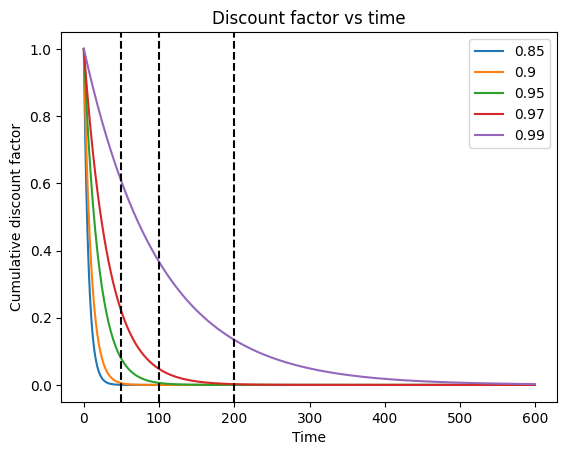

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(0.85 ** np.arange(600))
plt.plot(0.9 ** np.arange(600))
plt.plot(0.95 ** np.arange(600))
plt.plot(0.97 ** np.arange(600))
plt.plot(0.99 ** np.arange(600))
# plot vertical lines as 50, 100 , 200
plt.axvline(x=50, color='k', linestyle='--')
plt.axvline(x=100, color='k', linestyle='--')
plt.axvline(x=200, color='k', linestyle='--')
# add legend
plt.legend(['0.85', '0.9', '0.95', '0.97','0.99'])
# add title and labels
plt.title('Discount factor vs time')
plt.xlabel('Time')
plt.ylabel('Cumulative discount factor')

In [3]:
import importlib
# reimport f110_or_dataset
import gymnasium as gym
importlib.reload(gym)
importlib.reload(f110_orl_dataset)

/home/fabian/miniconda3/envs/f110_sb3/lib/python3.8/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment f110_with_dataset-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


<module 'f110_orl_dataset' from '/home/fabian/msc/f110_dope/rollouts/f1tenth_orl_dataset/f110_orl_dataset/__init__.py'>

In [4]:
F110Env = gym.make('f110_with_dataset-v0',
    # only terminals are available as of tight now 
        **dict(name='f110_with_dataset-v0',
            config = dict(map="Infsaal", num_agents=1),
              render_mode="human")
    )     

{'config': {'map': 'Infsaal', 'num_agents': 1}, 'render_mode': 'human'}
Infsaal_map.pgm
Infsaal_map.pgm
hi
Infsaal_map.pgm
Infsaal_map.pgm
===
Box([[-0.4189 -5.    ]], [[ 0.4189 20.    ]], (1, 2), float32)
low
20
Box([-30.     -30.      -1.      -1.     -20.     -20.     -20.      -0.4189
   0.5     -1.      -1.    ], [30.     30.      1.      1.     20.     20.     20.      0.4189  2.
  1.      1.    ], (11,), float32)
***********


/home/fabian/msc/f110_dope/rollouts/f1tenth_gym/gym/f110_gym/envs/integrator.py:13: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(
/home/fabian/miniconda3/envs/f110_sb3/lib/python3.8/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [7]:
root = F110Env.get_dataset(zarr_path="/home/fabian/msc/f110_dope/ws_ope/f1tenth_orl_dataset/data/trajectories_min_act.zarr",
                            alternate_reward=True,
                            only_agents="progress_weight",
                            clip_trajectory_length=(0,100),
                            )
#remove_short_trajectories=True)
print(root["observations"].shape)


TypeError: get_dataset() got an unexpected keyword argument 'clip_trajectory_length'

In [31]:
root.keys()

dict_keys(['rewards', 'terminals', 'timeouts', 'actions', 'log_probs', 'raw_actions', 'index', 'observations', 'scans', 'infos'])

In [39]:

print("raw",root["raw_actions"][:4])
print("action",np.clip(root["actions"][:3],-1,1)*0.05)
print(np.clip(root["actions"][:3],-1,1)*0.05 +root["observations"][:,7:9][1:4])
print(root["observations"][:,7:9][:5])

raw [[ 0.          1.17730672]
 [-0.03731743  1.12730672]
 [-0.00624715  1.14348614]
 [-0.02139929  1.13739785]]
action [[-0.03731743 -0.05      ]
 [ 0.03107028  0.01617942]
 [-0.01515214 -0.00608829]]
[[-0.03731743  1.12730672]
 [-0.00624716  1.14348614]
 [-0.02139929  1.13739785]]
[[ 0.          1.17730677]
 [ 0.          1.17730672]
 [-0.03731743  1.12730672]
 [-0.00624715  1.14348614]
 [-0.02139929  1.13739785]]


In [6]:
print(root["rewards"].shape)

(693350,)


In [7]:
import matplotlib.pyplot as plt

In [8]:
root.keys()

dict_keys(['rewards', 'terminals', 'timeouts', 'actions', 'log_probs', 'index', 'observations', 'scans', 'infos'])

In [9]:
root_obs = F110Env.unflatten_batch(root["observations"])

In [10]:
print(root_obs["previous_action"].shape)

(331850, 1, 2)


In [11]:
import numpy as np

In [12]:
print(np.sum(root["terminals"]))

6637


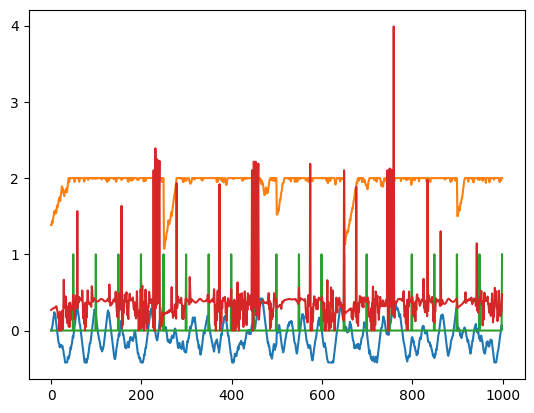

In [15]:
plt.plot(root_obs["previous_action"][:,0,:][:1000])
plt.plot(root["terminals"][:1000])
plt.plot(root["rewards"][:1000])

50
50
[6636]
[50]


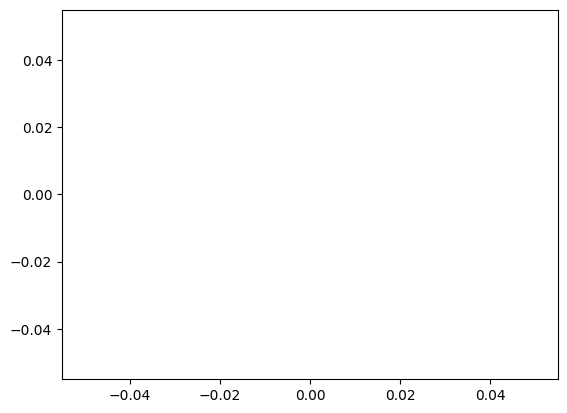

In [16]:
print(max(np.diff(np.where(root["terminals"])[0])))
print(min(np.diff(np.where(root["terminals"])[0])))
# print plot with counts of np.diff(np.where(root["terminals"])[0]))
uniques, counts = np.unique(np.diff(np.where(root["terminals"])[0]), return_counts=True)
plt.bar(uniques[:len(uniques)-1], counts[:len(uniques)-1])
print(counts)
print(uniques)

In [17]:
import numpy as np

In [18]:
model_names = root["infos"]["model_name"]
def get_change_indices(model_names):
    change_indices = []
    current_name = model_names[0]
    for idx, name in enumerate(model_names):
        if name != current_name:
            change_indices.append(idx)
            current_name = name
    return change_indices
change_indices = get_change_indices(model_names) + [len(model_names)]
print(change_indices)
model_names_ = [model_names[i-1] for i in change_indices]
print(change_indices[0],np.diff(change_indices))
print(model_names_)

[45650, 94000, 142450, 187750, 235600, 283500, 331850]
45650 [48350 48450 45300 47850 47900 48350]
['velocity', 'raceline', 'min_lida', 'td_progr', 'steering', 'min_acti', 'vel_chan']


In [19]:
poses_x = root_obs['poses_x'].squeeze(1)
poses_y = root_obs['poses_y'].squeeze(1)

In [20]:
print(poses_x.shape)

(331850,)


In [21]:
def plot_heatmap(start_idx, end_idx):
    # Extract relevant data
    x_data = poses_x[start_idx:end_idx]
    y_data = poses_y[start_idx:end_idx]

    # Create a 2D histogram (heatmap)
    plt.hist2d(x_data, y_data, bins=(100, 100), cmap=plt.cm.jet, range=[[-5, 2.5], [-1.5, 9]])
    plt.colorbar()
    plt.xlabel('poses_x')
    plt.ylabel('poses_y')
    plt.title(f'Heatmap for model: {model_names[start_idx]}')
    # plt size y from 0 to 0.4
    plt.show()


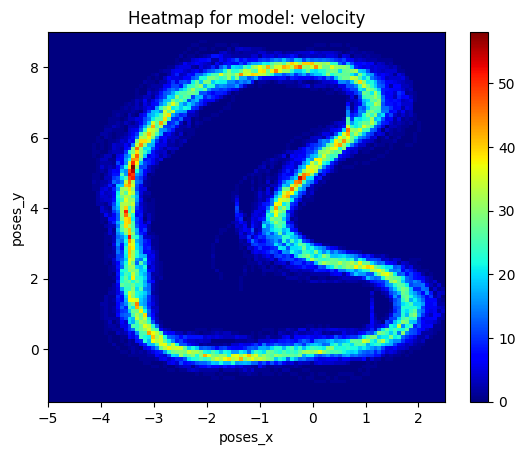

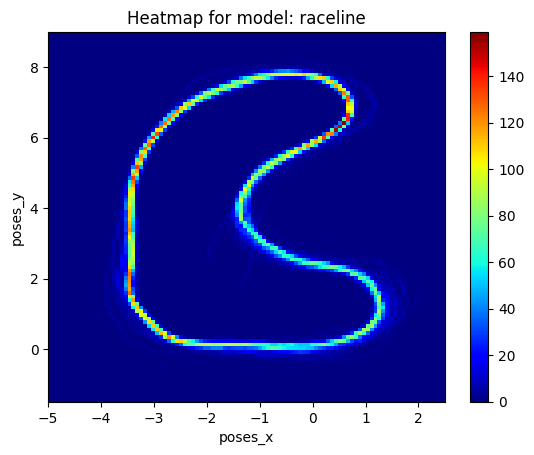

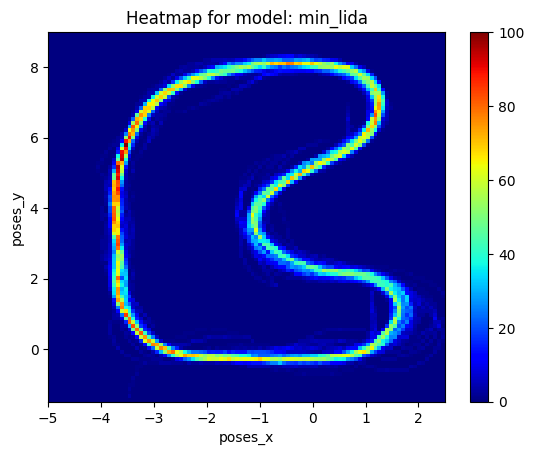

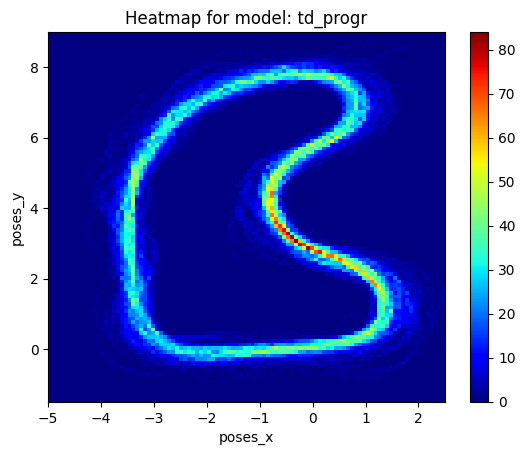

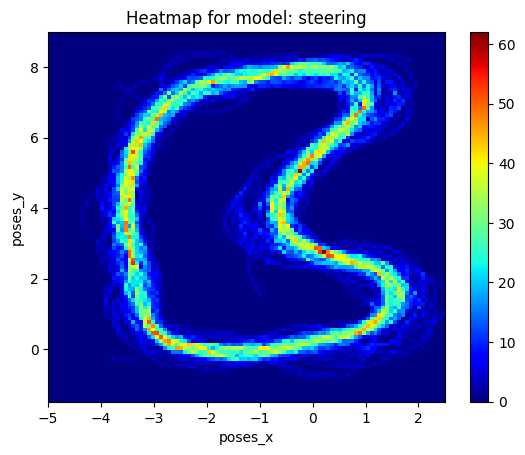

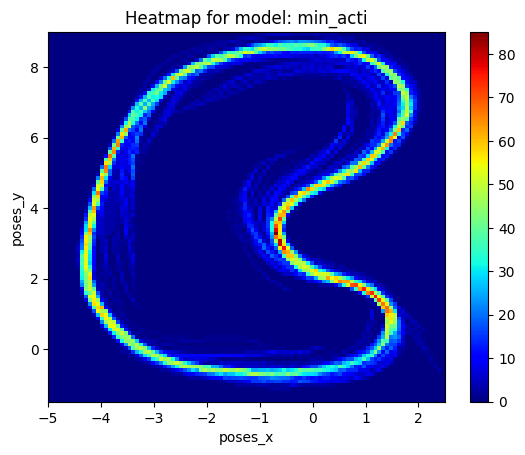

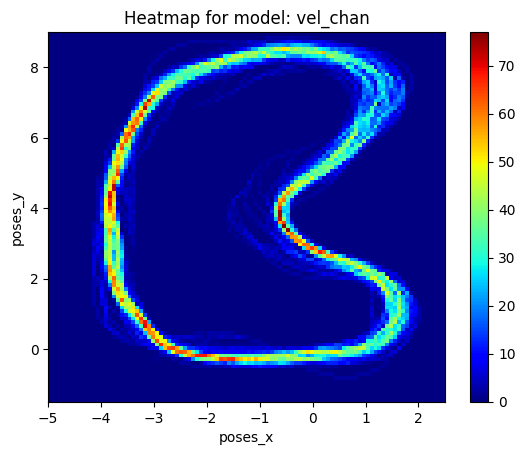

In [22]:
# Now, let's plot for each segment
start_idx = 0
for end_idx in change_indices:
    plot_heatmap(start_idx, end_idx)
    start_idx = end_idx

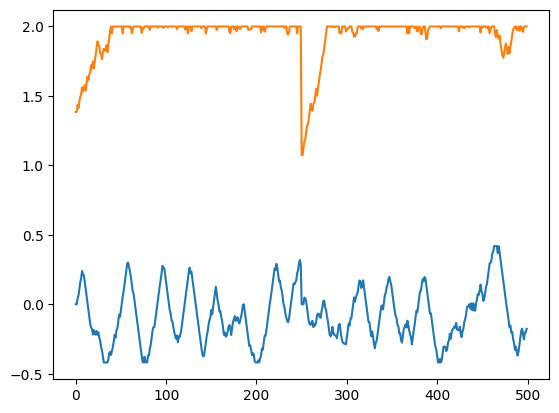

In [23]:
plt.plot(root_obs["previous_action"][:,0,:][:500])

In [24]:
# for each model the number of ored dones and truncates
print("Number of ores done and truncates for each model:")
done = root['terminals']
truncated = root['timeouts']
done_or_truncated = np.logical_or(done, truncated)
start_idx = 0
# print("Discounted TD Reward")
#model_names_ = []
for idx, change_idx in enumerate(change_indices):
    # count number of collisions for this model
    #model_names_.append(model_names[start_idx])
    num_done_or_truncated = np.sum(done_or_truncated[start_idx:change_idx])
    print(f'{model_names[start_idx]}: {num_done_or_truncated}')
    start_idx = change_idx

Number of ores done and truncates for each model:
velocity: 913
raceline: 967
min_lida: 969
td_progr: 906
steering: 957
min_acti: 958
vel_chan: 967


In [25]:
print(root.keys())

dict_keys(['rewards', 'terminals', 'timeouts', 'actions', 'log_probs', 'index', 'observations', 'scans', 'infos'])


In [26]:
import matplotlib.pyplot as plt
import numpy as np

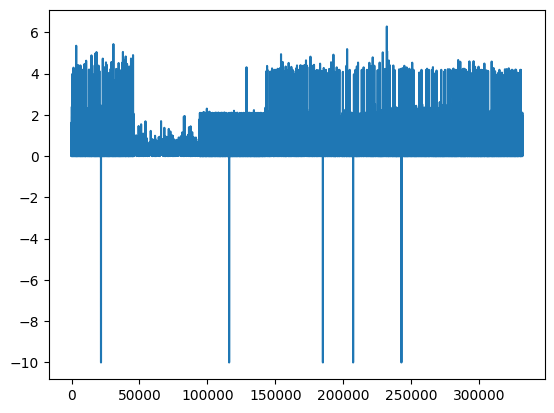

In [27]:

plt.plot(root["rewards"])
plt.show()

In [28]:
def calculate_discounted_reward(rewards, done, truncated, gamma=0.99):
    # combine done and truncated
    done_or_truncated = np.logical_or(done, truncated)
    # split into segments at done or truncated
    change_indices = np.where(done_or_truncated)[0] + 1 # catch the last segment
    # ensure that we dont access out of bounds, by checking if we are at the end
    change_indices[-1] = min(change_indices[-1], len(rewards)-1)
    # calculate discounted reward for each segment
    start_idx = 0
    discounted_rewards = []
    for end_idx in change_indices:
        segment_rewards = rewards[start_idx:end_idx] #[30:]
        #print(len(segment_rewards))
        discounted_reward = np.sum(segment_rewards * gamma ** np.arange(len(segment_rewards)))
        # print(f'Discounted reward: {discounted_reward}')
        discounted_rewards.append(discounted_reward)
        start_idx = end_idx
    return np.mean(discounted_rewards), np.std(discounted_rewards)

In [30]:
# for each model calculate the mean discounted reward
start_idx = 0
print("Discounted TD Reward")
gamma = 0.9
means = []
stds = []
# model_names_.append(model_names[start_idx])
for idx, change_idx in enumerate(change_indices): # this is for each model
    # count number of collisions for this model
    try:
        mean_discounted_reward, std_discounted = calculate_discounted_reward(root['rewards'][start_idx:change_idx],
                                    root['terminals'][start_idx:change_idx],
                                    root['timeouts'][start_idx:change_idx], gamma=gamma)
        print(f'{model_names[start_idx]}: {mean_discounted_reward} +- {std_discounted} ({mean_discounted_reward* (1-gamma)} +- {std_discounted * (1-gamma)})')
        means.append(mean_discounted_reward* (1-gamma))
        stds.append(std_discounted* (1-gamma))
        start_idx = change_idx
    except:
        print(0)
        

Discounted TD Reward
velocity: 3.5932516932181393 +- 0.8880791732069321 (0.35932516932181385 +- 0.0888079173206932)
raceline: 1.5953917130441801 +- 0.37869773404273305 (0.15953917130441797 +- 0.0378697734042733)
min_lida: 1.440478257007781 +- 0.5079710716758727 (0.14404782570077806 +- 0.050797107167587265)
td_progr: 3.3165038019414204 +- 0.82853442063973 (0.33165038019414195 +- 0.08285344206397298)
steering: 1.5187891259329698 +- 0.6115949108927189 (0.15187891259329694 +- 0.06115949108927188)
min_acti: 1.4409721716852604 +- 0.7371004510808674 (0.144097217168526 +- 0.07371004510808672)
vel_chan: 1.397594155518071 +- 0.6279228674233502 (0.13975941555180707 +- 0.06279228674233502)


In [31]:
print(model_names_)

['velocity', 'raceline', 'min_lida', 'td_progr', 'steering', 'min_acti', 'vel_chan']


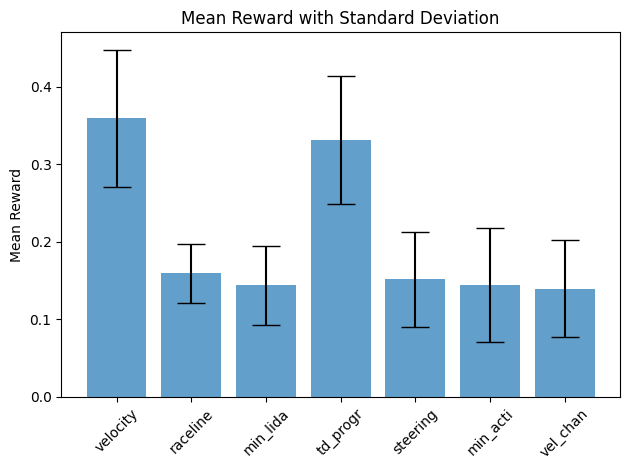

In [32]:
plt.bar(model_names_, means, yerr=stds, align='center', alpha=0.7, ecolor='black', capsize=10)
plt.ylabel('Mean Reward')
plt.title('Mean Reward with Standard Deviation')
plt.xticks(rotation=45)
plt.tight_layout()

In [33]:
def compute_trajectory_lengths(done, truncated):
    done_or_truncated = np.logical_or(done, truncated)
    # Add an ending point to ensure the last trajectory is considered
    # done_or_truncated = np.append(done_or_truncated, [1])
    lengths = []
    count = 0
    for flag in done_or_truncated:
        if flag:
            lengths.append(count + 1)
            count = 0
        else:
            count += 1
    return lengths

Statistics for each model:
velocity:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 45650

raceline:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 48350

min_lida:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 48450

td_progr:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 45300

steering:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 47850

min_acti:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 47900

vel_chan:
	Mean Length: 50.0
	Standard Deviation: 0.0
	Min Length: 50
	Max Length: 50

	Total Length: 48350

7
7
7


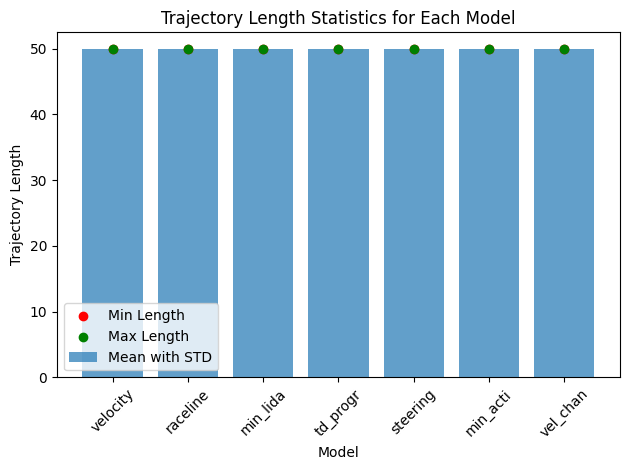

In [34]:
done = root['terminals']
truncated = root['timeouts']

start_idx = 0

# Lists for plotting
means = []
std_devs = []
mins = []
maxs = []

print("Statistics for each model:")
for idx, change_idx in enumerate(change_indices):
    current_lengths = compute_trajectory_lengths(done[start_idx:change_idx], truncated[start_idx:change_idx])

    mean_length = np.mean(current_lengths)
    std_dev = np.std(current_lengths)
    min_length = np.min(current_lengths)
    max_length = np.max(current_lengths)
    total_length = np.sum(current_lengths)
    print(f"{model_names[start_idx]}:")
    print(f"\tMean Length: {mean_length}")
    print(f"\tStandard Deviation: {std_dev}")
    print(f"\tMin Length: {min_length}")
    print(f"\tMax Length: {max_length}\n")
    print(f"\tTotal Length: {total_length}\n")
    # Add values to lists for plotting
    means.append(mean_length)
    std_devs.append(std_dev)
    mins.append(min_length)
    maxs.append(max_length)

    start_idx = change_idx

# Plotting
x = np.arange(len(np.unique(model_names)))
print(len(means))
print(len(std_devs))
print(len(x))
plt.bar(x, means, yerr=std_devs, label='Mean with STD', alpha=0.7)
plt.scatter(x, mins, color='red', label='Min Length', zorder=3)
plt.scatter(x, maxs, color='green', label='Max Length', zorder=3)

plt.xlabel('Model')
plt.ylabel('Trajectory Length')
plt.title('Trajectory Length Statistics for Each Model')
plt.xticks(x, model_names_, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

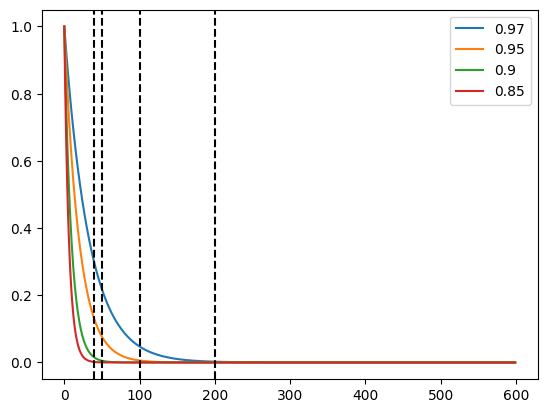

In [35]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(0.97 ** np.arange(600))
plt.plot(0.95 ** np.arange(600))
plt.plot(0.9 ** np.arange(600))
plt.plot(0.85 ** np.arange(600))
# plot vertical lines as 50, 100 , 200
plt.axvline(x=40, color='k', linestyle='--')
plt.axvline(x=50, color='k', linestyle='--')
plt.axvline(x=100, color='k', linestyle='--')
plt.axvline(x=200, color='k', linestyle='--')
# plot legend
plt.legend(['0.97', '0.95', '0.9', '0.85'])
# plt.plot(0.99 ** np.arange(1000))

In [55]:
print(root["observations"].shape)

(258800, 9)


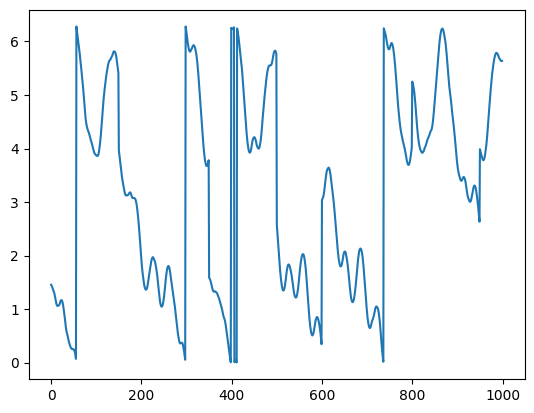

In [56]:
plt.plot(root["observations"][:1000,2])
plt.show()

In [30]:
print(discounted_returns)
print(max(discounted_returns))
# get argmax
print(np.argmax(discounted_returns))

[0.22419001889782492, 0.2291014891632704, 0.22758558787760497, 0.2284173734873712, 0.2183412345028362, 0.21978473976496313, 0.22320209044479186, 0.2285211108079324, 0.2317357281157974, 0.22622165801609218, 0.22689239671125794, 0.22982876556357756, 0.22729069805716126, 0.22354296990281103, 0.23168873999838077, 0.22733039864964572, 0.23253886185382017, 0.2254798480090844, 0.22970073358748574, 0.22454940092929299, 0.23083942500687551, 0.23763101238456397, 0.23058275444134993, 0.22671012368892896, 0.22759151356262378, 0.23260185810091158, 0.22936873480812486, 0.22509136902697388, 0.22994225734100077, 0.23273171021031197, 0.23290557102899098, 0.22886693703089184, 0.22924247885298507, 0.2264710881794249, 0.2243375559266521, 0.22987019727607622, 0.22194722562799096, 0.23116192719120532, 0.228334902824646, 0.22790574039458725, 0.23020537830449625, 0.231006450374601, 0.2322731066201018, 0.22772761019037313, 0.2310035220122918, 0.2315576326943134, 0.21978619895332407, 0.23338387301045205, 0.2187

In [15]:
# print mean and variance of discounted returns
print("mean and variance of discounted returns")
print(np.mean(discounted_returns))
print(np.var(discounted_returns))

mean and variance of discounted returns
21.138507718097383
1.9556561830439847


In [10]:
plt.plot(tr["rewards"])

TypeError: list indices must be integers or slices, not str

In [13]:
tr[0]["observations"].shape

(6, 435)

In [5]:
from f110_gym.envs.laser_models import ScanSimulator2D, check_ttc_jit, ray_cast

In [11]:
import numpy as np

In [25]:
# state is [x, y, steer_angle, vel, yaw_angle, yaw_rate, slip_angle]
state = np.array([[1.2, 5.0, 0.0, 0.0, 1.0, 0.0], [1.2, 5.0, 0.0, 0.0, 1.0, 0.0]])
scan = F110Env.sim.agents[0].scan_simulator.scan(np.array([1.2,5.0,1.0]),None)

In [57]:
print(tr["observations"][0:10].shape)
print(tr["obs_keys"][0:6])
print(tr["observations"].shape)
print(tr["observations"][1])
xy = tr["observations"][0:10, -2:]#[-2:]
print(xy)
theta = tr["observations"][0:10,-3]
# add dimension -1 to theta
theta = np.expand_dims(theta, axis=-1)
print(theta)
print(theta.shape)
print(xy.shape)
joined = np.hstack((xy, theta))
print(joined)

(10, 6)
['ang_vels_z' 'linear_vel_x' 'linear_vel_y' 'pose_theta' 'pose_x' 'pose_y']
(40895, 6)
[0.06851754 0.17578745 0.         1.00095689 1.20233607 5.00364065]
[[1.20001781 5.00002766]
 [1.20233607 5.00364065]
 [1.20988345 5.0155282 ]
 [1.22125268 5.0340395 ]
 [1.23421669 5.05907965]
 [1.24877167 5.08976269]
 [1.26334405 5.12578487]
 [1.27552319 5.16462326]
 [1.28915    5.20561981]
 [1.3053534  5.24621058]]
[[1.        ]
 [1.00095689]
 [1.01040018]
 [1.02811468]
 [1.04041481]
 [1.05728149]
 [1.08621335]
 [1.12724793]
 [1.15346038]
 [1.1592865 ]]
(10, 1)
(10, 2)
[[1.20001781 5.00002766 1.        ]
 [1.20233607 5.00364065 1.00095689]
 [1.20988345 5.0155282  1.01040018]
 [1.22125268 5.0340395  1.02811468]
 [1.23421669 5.05907965 1.04041481]
 [1.24877167 5.08976269 1.05728149]
 [1.26334405 5.12578487 1.08621335]
 [1.27552319 5.16462326 1.12724793]
 [1.28915    5.20561981 1.15346038]
 [1.3053534  5.24621058 1.1592865 ]]


(1080,)


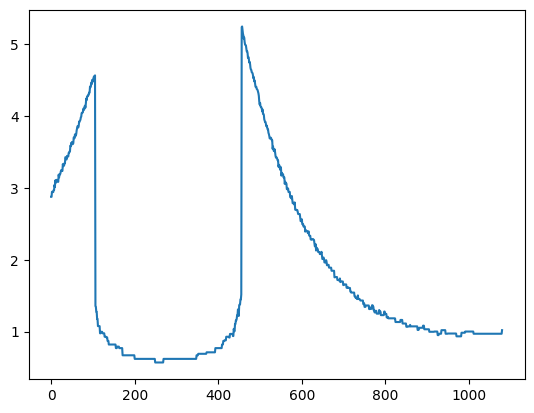

(1080,)


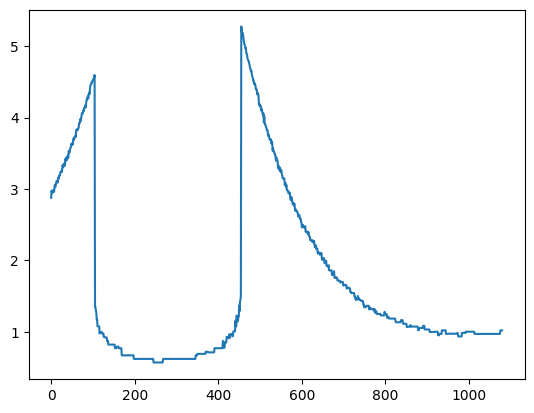

(1080,)


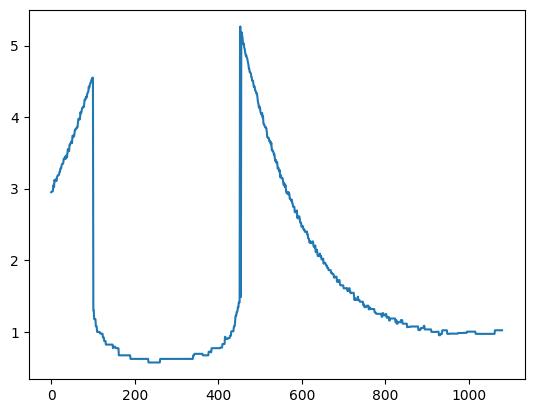

(1080,)


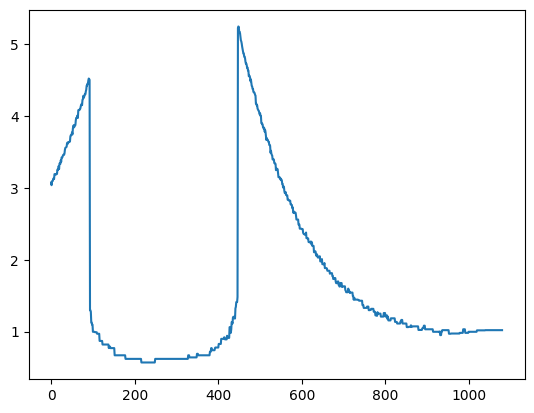

(1080,)


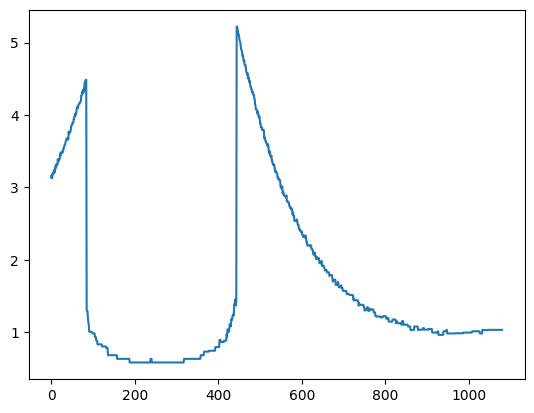

(1080,)


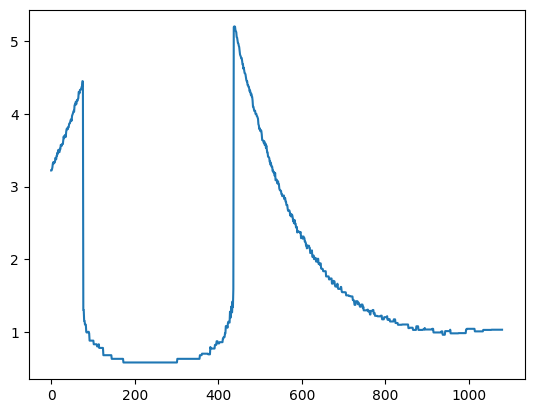

(1080,)


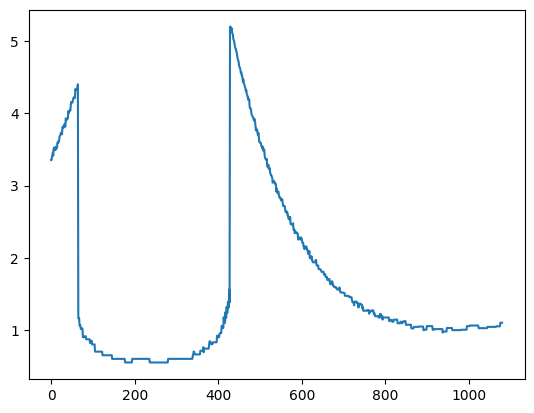

(1080,)


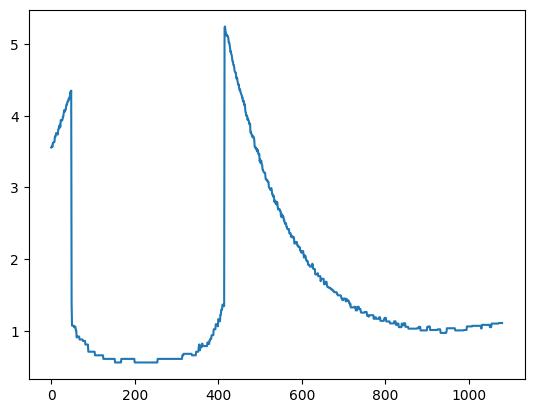

(1080,)


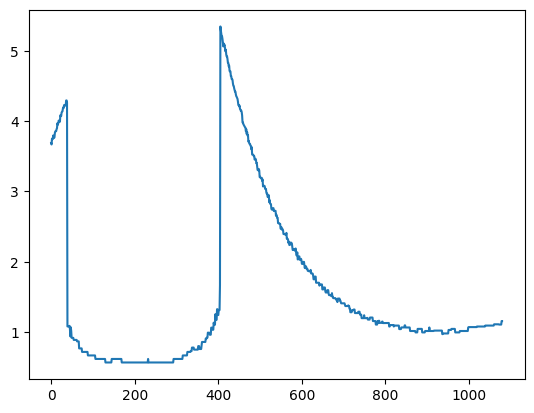

(1080,)


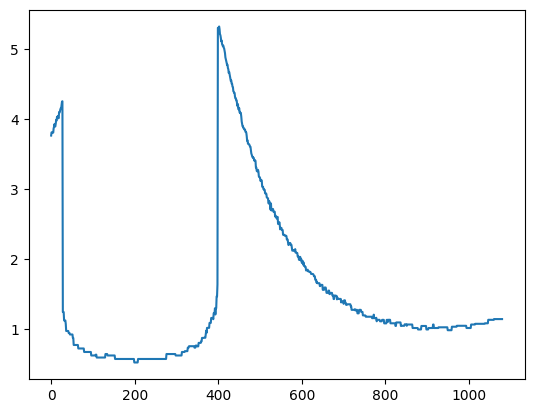

In [64]:
for pose in joined:
    scan = F110Env.sim.agents[0].scan_simulator.scan(pose,None)
    # TODO! downsample scan
    print(scan.shape)
    plt.plot(scan)
    plt.show()

In [42]:
print(joined)

[1.20233607 5.00364065 1.00095689]


In [21]:
import matplotlib.pyplot as plt

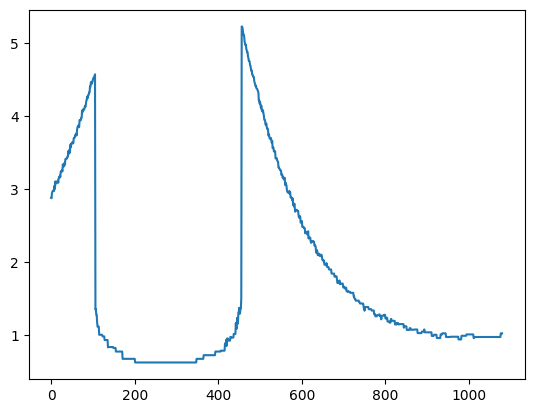

In [22]:
plt.plot(scan)